<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[23:12:38] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


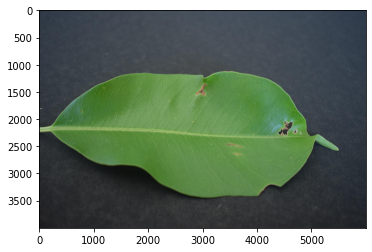

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

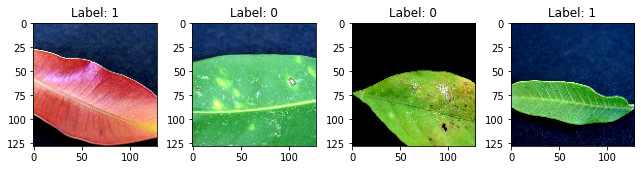

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[23:12:44] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[23:12:45] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[23:12:46] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.0787734304039025 samples/sec                   batch loss = 0.824394166469574 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2625884513589114 samples/sec                   batch loss = 0.3225659728050232 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2727548175656869 samples/sec                   batch loss = 0.5515997409820557 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2710550393762887 samples/sec                   batch loss = 0.9763956069946289 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.274842835110013 samples/sec                   batch loss = 0.8299274444580078 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2743212050182255 samples/sec                   batch loss = 0.44705620408058167 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2550001503557147 samples/sec                   batch loss = 0.3882290720939636 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2711217760957327 samples/sec                   batch loss = 0.8606458902359009 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2736169511777597 samples/sec                   batch loss = 0.5699566602706909 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2726045009735751 samples/sec                   batch loss = 0.5099629163742065 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2527003981231764 samples/sec                   batch loss = 0.8811267018318176 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.260276166469093 samples/sec                   batch loss = 0.9117829203605652 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2624635156729476 samples/sec                   batch loss = 0.4888497591018677 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2626329211284153 samples/sec                   batch loss = 0.8535680770874023 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2770413273629737 samples/sec                   batch loss = 0.41016674041748047 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.2713541092012206 samples/sec                   batch loss = 0.4868597090244293 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.269456322245413 samples/sec                   batch loss = 0.5393293499946594 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2753685765452272 samples/sec                   batch loss = 0.4769235849380493 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.271948813987633 samples/sec                   batch loss = 0.22551380097866058 | accuracy = 0.6578947368421053


Epoch[1] Batch[100] Speed: 1.267833549208115 samples/sec                   batch loss = 1.765506625175476 | accuracy = 0.65


Epoch[1] Batch[105] Speed: 1.2655696174267832 samples/sec                   batch loss = 1.7919243574142456 | accuracy = 0.6476190476190476


Epoch[1] Batch[110] Speed: 1.268923638055632 samples/sec                   batch loss = 0.4809688925743103 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.2688723903063845 samples/sec                   batch loss = 0.5507547855377197 | accuracy = 0.6543478260869565


Epoch[1] Batch[120] Speed: 1.2660644240929932 samples/sec                   batch loss = 0.6204555630683899 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.2694125231150106 samples/sec                   batch loss = 1.32564115524292 | accuracy = 0.658


Epoch[1] Batch[130] Speed: 1.270033581232844 samples/sec                   batch loss = 0.692890465259552 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.2761976569443518 samples/sec                   batch loss = 0.6657961010932922 | accuracy = 0.65


Epoch[1] Batch[140] Speed: 1.2674723578316158 samples/sec                   batch loss = 0.833598256111145 | accuracy = 0.6535714285714286


Epoch[1] Batch[145] Speed: 1.2708834628427987 samples/sec                   batch loss = 0.7648993730545044 | accuracy = 0.656896551724138


Epoch[1] Batch[150] Speed: 1.2722840021048496 samples/sec                   batch loss = 0.5154430866241455 | accuracy = 0.66


Epoch[1] Batch[155] Speed: 1.263786142146051 samples/sec                   batch loss = 0.8277872800827026 | accuracy = 0.6596774193548387


Epoch[1] Batch[160] Speed: 1.274382477082945 samples/sec                   batch loss = 0.3421497941017151 | accuracy = 0.6625


Epoch[1] Batch[165] Speed: 1.2722323860984865 samples/sec                   batch loss = 0.5873672962188721 | accuracy = 0.6636363636363637


Epoch[1] Batch[170] Speed: 1.2612357124251206 samples/sec                   batch loss = 0.7516071796417236 | accuracy = 0.6617647058823529


Epoch[1] Batch[175] Speed: 1.2571153257521746 samples/sec                   batch loss = 0.6871498227119446 | accuracy = 0.66


Epoch[1] Batch[180] Speed: 1.268462365477582 samples/sec                   batch loss = 0.6535519957542419 | accuracy = 0.6611111111111111


Epoch[1] Batch[185] Speed: 1.2707720880629099 samples/sec                   batch loss = 0.7306867837905884 | accuracy = 0.6608108108108108


Epoch[1] Batch[190] Speed: 1.2643632094863173 samples/sec                   batch loss = 0.15067815780639648 | accuracy = 0.6657894736842105


Epoch[1] Batch[195] Speed: 1.2662003941419684 samples/sec                   batch loss = 0.2226664274930954 | accuracy = 0.6743589743589744


Epoch[1] Batch[200] Speed: 1.2640662763936459 samples/sec                   batch loss = 1.181060552597046 | accuracy = 0.67375


Epoch[1] Batch[205] Speed: 1.2618243080625753 samples/sec                   batch loss = 0.5784801840782166 | accuracy = 0.6743902439024391


Epoch[1] Batch[210] Speed: 1.2640765624069963 samples/sec                   batch loss = 0.5566378831863403 | accuracy = 0.6726190476190477


Epoch[1] Batch[215] Speed: 1.2763172669193352 samples/sec                   batch loss = 0.7864987254142761 | accuracy = 0.6744186046511628


Epoch[1] Batch[220] Speed: 1.2702074287061063 samples/sec                   batch loss = 0.5896494388580322 | accuracy = 0.6727272727272727


Epoch[1] Batch[225] Speed: 1.272082578682985 samples/sec                   batch loss = 0.686936616897583 | accuracy = 0.6722222222222223


Epoch[1] Batch[230] Speed: 1.2644458268398517 samples/sec                   batch loss = 0.8298912644386292 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.271414903561424 samples/sec                   batch loss = 0.8203585147857666 | accuracy = 0.6712765957446809


Epoch[1] Batch[240] Speed: 1.2727630246960033 samples/sec                   batch loss = 0.630773663520813 | accuracy = 0.6697916666666667


Epoch[1] Batch[245] Speed: 1.2631671832231393 samples/sec                   batch loss = 0.3351573944091797 | accuracy = 0.6693877551020408


Epoch[1] Batch[250] Speed: 1.2603733051908426 samples/sec                   batch loss = 0.4474525451660156 | accuracy = 0.672


Epoch[1] Batch[255] Speed: 1.2732085892852874 samples/sec                   batch loss = 0.4777809679508209 | accuracy = 0.6735294117647059


Epoch[1] Batch[260] Speed: 1.2695944629836666 samples/sec                   batch loss = 0.3828243017196655 | accuracy = 0.6759615384615385


Epoch[1] Batch[265] Speed: 1.2643939872385048 samples/sec                   batch loss = 0.6641420722007751 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.2713518933517949 samples/sec                   batch loss = 0.8779208064079285 | accuracy = 0.6759259259259259


Epoch[1] Batch[275] Speed: 1.2711576993379867 samples/sec                   batch loss = 0.7794739007949829 | accuracy = 0.6772727272727272


Epoch[1] Batch[280] Speed: 1.2636362232699039 samples/sec                   batch loss = 0.5637704133987427 | accuracy = 0.6767857142857143


Epoch[1] Batch[285] Speed: 1.2703479453141824 samples/sec                   batch loss = 0.48604536056518555 | accuracy = 0.6789473684210526


Epoch[1] Batch[290] Speed: 1.2696801676195388 samples/sec                   batch loss = 0.35129523277282715 | accuracy = 0.6810344827586207


Epoch[1] Batch[295] Speed: 1.2682758602442554 samples/sec                   batch loss = 0.7900788187980652 | accuracy = 0.6796610169491526


Epoch[1] Batch[300] Speed: 1.2665368615836543 samples/sec                   batch loss = 0.2831505239009857 | accuracy = 0.6816666666666666


Epoch[1] Batch[305] Speed: 1.2682435510301766 samples/sec                   batch loss = 0.6182257533073425 | accuracy = 0.6811475409836065


Epoch[1] Batch[310] Speed: 1.2692086472113666 samples/sec                   batch loss = 0.26434725522994995 | accuracy = 0.682258064516129


Epoch[1] Batch[315] Speed: 1.2692944918230782 samples/sec                   batch loss = 0.7717309594154358 | accuracy = 0.6833333333333333


Epoch[1] Batch[320] Speed: 1.269393121834597 samples/sec                   batch loss = 0.251777708530426 | accuracy = 0.68359375


Epoch[1] Batch[325] Speed: 1.2698962100099869 samples/sec                   batch loss = 1.2036805152893066 | accuracy = 0.6838461538461539


Epoch[1] Batch[330] Speed: 1.2716952494376477 samples/sec                   batch loss = 0.22067834436893463 | accuracy = 0.6878787878787879


Epoch[1] Batch[335] Speed: 1.2693587388439806 samples/sec                   batch loss = 0.09372784197330475 | accuracy = 0.6902985074626866


Epoch[1] Batch[340] Speed: 1.2713023759492117 samples/sec                   batch loss = 1.6232904195785522 | accuracy = 0.6889705882352941


Epoch[1] Batch[345] Speed: 1.264786225082008 samples/sec                   batch loss = 0.3068331778049469 | accuracy = 0.6876811594202898


Epoch[1] Batch[350] Speed: 1.2682935015781838 samples/sec                   batch loss = 0.42858803272247314 | accuracy = 0.6892857142857143


Epoch[1] Batch[355] Speed: 1.259844525307478 samples/sec                   batch loss = 0.4180775284767151 | accuracy = 0.6908450704225352


Epoch[1] Batch[360] Speed: 1.2685331463436063 samples/sec                   batch loss = 0.21131394803524017 | accuracy = 0.6909722222222222


Epoch[1] Batch[365] Speed: 1.2682552473508117 samples/sec                   batch loss = 0.7287036776542664 | accuracy = 0.6917808219178082


Epoch[1] Batch[370] Speed: 1.2592003111446386 samples/sec                   batch loss = 0.3401026129722595 | accuracy = 0.6912162162162162


Epoch[1] Batch[375] Speed: 1.2675213857954666 samples/sec                   batch loss = 0.8892913460731506 | accuracy = 0.6906666666666667


Epoch[1] Batch[380] Speed: 1.2691263663527366 samples/sec                   batch loss = 0.5649107694625854 | accuracy = 0.6901315789473684


Epoch[1] Batch[385] Speed: 1.2659249489792108 samples/sec                   batch loss = 0.8143212795257568 | accuracy = 0.6909090909090909


Epoch[1] Batch[390] Speed: 1.265189773760406 samples/sec                   batch loss = 0.8511872887611389 | accuracy = 0.6884615384615385


Epoch[1] Batch[395] Speed: 1.2677222293670416 samples/sec                   batch loss = 0.2229776233434677 | accuracy = 0.689873417721519


Epoch[1] Batch[400] Speed: 1.2646807783132916 samples/sec                   batch loss = 1.0065560340881348 | accuracy = 0.690625


Epoch[1] Batch[405] Speed: 1.2696849720335373 samples/sec                   batch loss = 0.28499433398246765 | accuracy = 0.691358024691358


Epoch[1] Batch[410] Speed: 1.2695893710320167 samples/sec                   batch loss = 0.5815008878707886 | accuracy = 0.6908536585365853


Epoch[1] Batch[415] Speed: 1.2661841488192873 samples/sec                   batch loss = 1.1485934257507324 | accuracy = 0.6897590361445783


Epoch[1] Batch[420] Speed: 1.2681907285316865 samples/sec                   batch loss = 0.306837797164917 | accuracy = 0.6916666666666667


Epoch[1] Batch[425] Speed: 1.2701882916145788 samples/sec                   batch loss = 0.17372579872608185 | accuracy = 0.6929411764705883


Epoch[1] Batch[430] Speed: 1.2722073031963788 samples/sec                   batch loss = 1.1940929889678955 | accuracy = 0.6924418604651162


Epoch[1] Batch[435] Speed: 1.27115009076063 samples/sec                   batch loss = 0.24237650632858276 | accuracy = 0.6925287356321839


Epoch[1] Batch[440] Speed: 1.2647747833525305 samples/sec                   batch loss = 0.3986356258392334 | accuracy = 0.6920454545454545


Epoch[1] Batch[445] Speed: 1.2640919917409 samples/sec                   batch loss = 0.3119044303894043 | accuracy = 0.6932584269662921


Epoch[1] Batch[450] Speed: 1.2689465761233725 samples/sec                   batch loss = 0.5765575766563416 | accuracy = 0.6922222222222222


Epoch[1] Batch[455] Speed: 1.2738301766384967 samples/sec                   batch loss = 0.4695306718349457 | accuracy = 0.6912087912087912


Epoch[1] Batch[460] Speed: 1.275493752350609 samples/sec                   batch loss = 0.2364727258682251 | accuracy = 0.6923913043478261


Epoch[1] Batch[465] Speed: 1.2701958886823952 samples/sec                   batch loss = 0.37701842188835144 | accuracy = 0.6935483870967742


Epoch[1] Batch[470] Speed: 1.2706055917437828 samples/sec                   batch loss = 0.5513235926628113 | accuracy = 0.6946808510638298


Epoch[1] Batch[475] Speed: 1.2648372386448827 samples/sec                   batch loss = 0.9963146448135376 | accuracy = 0.6942105263157895


Epoch[1] Batch[480] Speed: 1.2695747679255225 samples/sec                   batch loss = 0.9964197874069214 | accuracy = 0.6921875


Epoch[1] Batch[485] Speed: 1.2654551631331503 samples/sec                   batch loss = 0.6068667769432068 | accuracy = 0.6932989690721649


Epoch[1] Batch[490] Speed: 1.26666078782161 samples/sec                   batch loss = 0.42913395166397095 | accuracy = 0.6938775510204082


Epoch[1] Batch[495] Speed: 1.2659915301827602 samples/sec                   batch loss = 0.3654477596282959 | accuracy = 0.6964646464646465


Epoch[1] Batch[500] Speed: 1.2685491642480462 samples/sec                   batch loss = 1.108765721321106 | accuracy = 0.696


Epoch[1] Batch[505] Speed: 1.2735091568585255 samples/sec                   batch loss = 0.5605109333992004 | accuracy = 0.694059405940594


Epoch[1] Batch[510] Speed: 1.2718258755809924 samples/sec                   batch loss = 0.3267345130443573 | accuracy = 0.696078431372549


Epoch[1] Batch[515] Speed: 1.2649925931365855 samples/sec                   batch loss = 1.5950121879577637 | accuracy = 0.6951456310679611


Epoch[1] Batch[520] Speed: 1.2671599894078662 samples/sec                   batch loss = 1.1263147592544556 | accuracy = 0.6947115384615384


Epoch[1] Batch[525] Speed: 1.2735357412061732 samples/sec                   batch loss = 0.7057353854179382 | accuracy = 0.6938095238095238


Epoch[1] Batch[530] Speed: 1.272107077933279 samples/sec                   batch loss = 1.2053756713867188 | accuracy = 0.6933962264150944


Epoch[1] Batch[535] Speed: 1.2659581909428523 samples/sec                   batch loss = 0.47674691677093506 | accuracy = 0.6929906542056075


Epoch[1] Batch[540] Speed: 1.2672986838074973 samples/sec                   batch loss = 0.4445573091506958 | accuracy = 0.6935185185185185


Epoch[1] Batch[545] Speed: 1.268675883006556 samples/sec                   batch loss = 1.0310801267623901 | accuracy = 0.6935779816513762


Epoch[1] Batch[550] Speed: 1.263997231100426 samples/sec                   batch loss = 1.8719853162765503 | accuracy = 0.695


Epoch[1] Batch[555] Speed: 1.2717727542587958 samples/sec                   batch loss = 0.5416449904441833 | accuracy = 0.6963963963963964


Epoch[1] Batch[560] Speed: 1.2731351602591465 samples/sec                   batch loss = 0.24648374319076538 | accuracy = 0.6973214285714285


Epoch[1] Batch[565] Speed: 1.2757856014274136 samples/sec                   batch loss = 1.1571218967437744 | accuracy = 0.6960176991150443


Epoch[1] Batch[570] Speed: 1.2665476659156458 samples/sec                   batch loss = 0.3518223166465759 | accuracy = 0.6960526315789474


Epoch[1] Batch[575] Speed: 1.2695766893677103 samples/sec                   batch loss = 0.27000850439071655 | accuracy = 0.697391304347826


Epoch[1] Batch[580] Speed: 1.2688262324876896 samples/sec                   batch loss = 0.1149013563990593 | accuracy = 0.6987068965517241


Epoch[1] Batch[585] Speed: 1.2677391847416855 samples/sec                   batch loss = 0.40438467264175415 | accuracy = 0.6982905982905983


Epoch[1] Batch[590] Speed: 1.2709698230180073 samples/sec                   batch loss = 0.6289878487586975 | accuracy = 0.6974576271186441


Epoch[1] Batch[595] Speed: 1.2655409780468392 samples/sec                   batch loss = 0.4622006118297577 | accuracy = 0.6983193277310924


Epoch[1] Batch[600] Speed: 1.2677146618603392 samples/sec                   batch loss = 0.644484281539917 | accuracy = 0.69875


Epoch[1] Batch[605] Speed: 1.2605070137668253 samples/sec                   batch loss = 0.45493847131729126 | accuracy = 0.7


Epoch[1] Batch[610] Speed: 1.268781901112516 samples/sec                   batch loss = 0.1095462292432785 | accuracy = 0.7008196721311475


Epoch[1] Batch[615] Speed: 1.2678232019616282 samples/sec                   batch loss = 0.4875364899635315 | accuracy = 0.6995934959349593


Epoch[1] Batch[620] Speed: 1.274307267172089 samples/sec                   batch loss = 0.17502635717391968 | accuracy = 0.7008064516129032


Epoch[1] Batch[625] Speed: 1.2624338767666097 samples/sec                   batch loss = 0.3663327097892761 | accuracy = 0.7016


Epoch[1] Batch[630] Speed: 1.2627002018623479 samples/sec                   batch loss = 0.5807620882987976 | accuracy = 0.7015873015873015


Epoch[1] Batch[635] Speed: 1.2737480691315073 samples/sec                   batch loss = 0.5111660957336426 | accuracy = 0.7015748031496063


Epoch[1] Batch[640] Speed: 1.2668920668975643 samples/sec                   batch loss = 0.45895126461982727 | accuracy = 0.701953125


Epoch[1] Batch[645] Speed: 1.2732445339489433 samples/sec                   batch loss = 0.5687233209609985 | accuracy = 0.7027131782945737


Epoch[1] Batch[650] Speed: 1.268970186883463 samples/sec                   batch loss = 0.16118374466896057 | accuracy = 0.7034615384615385


Epoch[1] Batch[655] Speed: 1.270213294965214 samples/sec                   batch loss = 0.8698810338973999 | accuracy = 0.7026717557251908


Epoch[1] Batch[660] Speed: 1.2696417336164443 samples/sec                   batch loss = 0.1869465410709381 | accuracy = 0.703030303030303


Epoch[1] Batch[665] Speed: 1.2669770243392087 samples/sec                   batch loss = 0.37419480085372925 | accuracy = 0.7030075187969925


Epoch[1] Batch[670] Speed: 1.2680630523895957 samples/sec                   batch loss = 0.16286569833755493 | accuracy = 0.7029850746268657


Epoch[1] Batch[675] Speed: 1.260720987559323 samples/sec                   batch loss = 0.42204880714416504 | accuracy = 0.7037037037037037


Epoch[1] Batch[680] Speed: 1.2596416303008047 samples/sec                   batch loss = 1.0901652574539185 | accuracy = 0.7040441176470589


Epoch[1] Batch[685] Speed: 1.2668665244892785 samples/sec                   batch loss = 0.5406609177589417 | accuracy = 0.7032846715328467


Epoch[1] Batch[690] Speed: 1.2719306851051912 samples/sec                   batch loss = 0.49795353412628174 | accuracy = 0.7043478260869566


Epoch[1] Batch[695] Speed: 1.2649679856460365 samples/sec                   batch loss = 0.29133421182632446 | accuracy = 0.7053956834532374


Epoch[1] Batch[700] Speed: 1.2602500381405328 samples/sec                   batch loss = 0.481557160615921 | accuracy = 0.7042857142857143


Epoch[1] Batch[705] Speed: 1.2675096072470668 samples/sec                   batch loss = 0.27043241262435913 | accuracy = 0.7039007092198581


Epoch[1] Batch[710] Speed: 1.2644901416335839 samples/sec                   batch loss = 0.5658713579177856 | accuracy = 0.7049295774647887


Epoch[1] Batch[715] Speed: 1.2691249262926816 samples/sec                   batch loss = 0.5599018335342407 | accuracy = 0.7055944055944056


Epoch[1] Batch[720] Speed: 1.264836380438766 samples/sec                   batch loss = 0.9182454347610474 | accuracy = 0.7052083333333333


Epoch[1] Batch[725] Speed: 1.2630188373856892 samples/sec                   batch loss = 0.1775386929512024 | accuracy = 0.7058620689655173


Epoch[1] Batch[730] Speed: 1.2645587642170582 samples/sec                   batch loss = 0.3142305612564087 | accuracy = 0.7061643835616438


Epoch[1] Batch[735] Speed: 1.2627790852996779 samples/sec                   batch loss = 0.3641859292984009 | accuracy = 0.7061224489795919


Epoch[1] Batch[740] Speed: 1.270190695740135 samples/sec                   batch loss = 0.37416064739227295 | accuracy = 0.7057432432432432


Epoch[1] Batch[745] Speed: 1.272559326047544 samples/sec                   batch loss = 0.7084411382675171 | accuracy = 0.7063758389261745


Epoch[1] Batch[750] Speed: 1.2663354375752671 samples/sec                   batch loss = 0.4747142791748047 | accuracy = 0.7056666666666667


Epoch[1] Batch[755] Speed: 1.2709103227769165 samples/sec                   batch loss = 0.869554877281189 | accuracy = 0.7052980132450332


Epoch[1] Batch[760] Speed: 1.27125363301304 samples/sec                   batch loss = 0.6996133327484131 | accuracy = 0.7046052631578947


Epoch[1] Batch[765] Speed: 1.266557514272652 samples/sec                   batch loss = 0.6859943866729736 | accuracy = 0.7049019607843138


Epoch[1] Batch[770] Speed: 1.263006571885807 samples/sec                   batch loss = 0.5600355863571167 | accuracy = 0.7055194805194805


Epoch[1] Batch[775] Speed: 1.2634815823402539 samples/sec                   batch loss = 0.5337570905685425 | accuracy = 0.7058064516129032


Epoch[1] Batch[780] Speed: 1.2691677454743597 samples/sec                   batch loss = 0.2576172947883606 | accuracy = 0.7060897435897436


Epoch[1] Batch[785] Speed: 1.2699107243893217 samples/sec                   batch loss = 0.6806461811065674 | accuracy = 0.7070063694267515


[Epoch 1] training: accuracy=0.7074873096446701
[Epoch 1] time cost: 645.8389070034027
[Epoch 1] validation: validation accuracy=0.7477777777777778


Epoch[2] Batch[5] Speed: 1.2697775121415187 samples/sec                   batch loss = 0.832737922668457 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2651139277846946 samples/sec                   batch loss = 0.5386978983879089 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2709003103389973 samples/sec                   batch loss = 0.5102976560592651 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2723236576198897 samples/sec                   batch loss = 0.3138485848903656 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2709362210644533 samples/sec                   batch loss = 0.5899848937988281 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2735397047858046 samples/sec                   batch loss = 0.7653839588165283 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2666646130913013 samples/sec                   batch loss = 0.37278735637664795 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2677782700448563 samples/sec                   batch loss = 0.15472312271595 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2685227876746872 samples/sec                   batch loss = 0.4971092641353607 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2656205987303373 samples/sec                   batch loss = 0.5211743116378784 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.269635488310718 samples/sec                   batch loss = 0.4765399992465973 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2719400387725577 samples/sec                   batch loss = 0.4579348862171173 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2770522144509724 samples/sec                   batch loss = 0.6849420070648193 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.266515253472662 samples/sec                   batch loss = 0.696443498134613 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.271752413148888 samples/sec                   batch loss = 0.524746835231781 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2640776100658975 samples/sec                   batch loss = 0.3443026542663574 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2667441839394278 samples/sec                   batch loss = 0.8477689623832703 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2717801774799187 samples/sec                   batch loss = 0.4440189301967621 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2693180194989917 samples/sec                   batch loss = 0.2995952367782593 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2790423186252602 samples/sec                   batch loss = 0.7592422962188721 | accuracy = 0.7575


Epoch[2] Batch[105] Speed: 1.27185721056505 samples/sec                   batch loss = 0.5820101499557495 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.273940346918565 samples/sec                   batch loss = 0.26141583919525146 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.269054463346341 samples/sec                   batch loss = 0.796146810054779 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2738715728933763 samples/sec                   batch loss = 0.6477803587913513 | accuracy = 0.7625


Epoch[2] Batch[125] Speed: 1.271986037674624 samples/sec                   batch loss = 0.598945140838623 | accuracy = 0.766


Epoch[2] Batch[130] Speed: 1.2744698943503356 samples/sec                   batch loss = 0.4093974232673645 | accuracy = 0.7615384615384615


Epoch[2] Batch[135] Speed: 1.2752863675413584 samples/sec                   batch loss = 0.5043601989746094 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.270723097043382 samples/sec                   batch loss = 0.3094353675842285 | accuracy = 0.7660714285714286


Epoch[2] Batch[145] Speed: 1.275921241757991 samples/sec                   batch loss = 0.36389151215553284 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.279826683627057 samples/sec                   batch loss = 0.2996809184551239 | accuracy = 0.7633333333333333


Epoch[2] Batch[155] Speed: 1.2749784688189818 samples/sec                   batch loss = 0.12614966928958893 | accuracy = 0.7693548387096775


Epoch[2] Batch[160] Speed: 1.2689619326154113 samples/sec                   batch loss = 0.7126304507255554 | accuracy = 0.76875


Epoch[2] Batch[165] Speed: 1.2729904525807108 samples/sec                   batch loss = 0.2416645735502243 | accuracy = 0.7681818181818182


Epoch[2] Batch[170] Speed: 1.2688115509749085 samples/sec                   batch loss = 0.44845467805862427 | accuracy = 0.763235294117647


Epoch[2] Batch[175] Speed: 1.2679468051129559 samples/sec                   batch loss = 0.9578387141227722 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.2669351182311557 samples/sec                   batch loss = 0.3365693986415863 | accuracy = 0.7625


Epoch[2] Batch[185] Speed: 1.267212534645471 samples/sec                   batch loss = 0.35120707750320435 | accuracy = 0.7648648648648648


Epoch[2] Batch[190] Speed: 1.2667230469578463 samples/sec                   batch loss = 0.435331255197525 | accuracy = 0.7631578947368421


Epoch[2] Batch[195] Speed: 1.272648810266564 samples/sec                   batch loss = 0.17348140478134155 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2690145314172925 samples/sec                   batch loss = 0.4866328239440918 | accuracy = 0.765


Epoch[2] Batch[205] Speed: 1.2774529300785316 samples/sec                   batch loss = 0.39305442571640015 | accuracy = 0.7634146341463415


Epoch[2] Batch[210] Speed: 1.2700113729541702 samples/sec                   batch loss = 0.6834713816642761 | accuracy = 0.763095238095238


Epoch[2] Batch[215] Speed: 1.2716519703833287 samples/sec                   batch loss = 0.14776186645030975 | accuracy = 0.7616279069767442


Epoch[2] Batch[220] Speed: 1.2734259308595623 samples/sec                   batch loss = 0.1583530753850937 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2748484536478075 samples/sec                   batch loss = 0.5372728109359741 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.2639694246440352 samples/sec                   batch loss = 0.8291447758674622 | accuracy = 0.7565217391304347


Epoch[2] Batch[235] Speed: 1.2675787494975688 samples/sec                   batch loss = 0.12751765549182892 | accuracy = 0.7574468085106383


Epoch[2] Batch[240] Speed: 1.269171297868104 samples/sec                   batch loss = 0.434987336397171 | accuracy = 0.7614583333333333


Epoch[2] Batch[245] Speed: 1.2676139938793853 samples/sec                   batch loss = 0.8854848146438599 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2760437115212402 samples/sec                   batch loss = 0.37499573826789856 | accuracy = 0.758


Epoch[2] Batch[255] Speed: 1.2705616170526455 samples/sec                   batch loss = 0.4789589047431946 | accuracy = 0.7578431372549019


Epoch[2] Batch[260] Speed: 1.2710169072542334 samples/sec                   batch loss = 0.6151843070983887 | accuracy = 0.7576923076923077


Epoch[2] Batch[265] Speed: 1.2752950920508415 samples/sec                   batch loss = 0.6831448078155518 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.274796048175531 samples/sec                   batch loss = 0.18663524091243744 | accuracy = 0.7648148148148148


Epoch[2] Batch[275] Speed: 1.27115009076063 samples/sec                   batch loss = 0.21888895332813263 | accuracy = 0.7681818181818182


Epoch[2] Batch[280] Speed: 1.277048034564877 samples/sec                   batch loss = 0.340072363615036 | accuracy = 0.7678571428571429


Epoch[2] Batch[285] Speed: 1.273474550534246 samples/sec                   batch loss = 0.48171547055244446 | accuracy = 0.769298245614035


Epoch[2] Batch[290] Speed: 1.2807817271283743 samples/sec                   batch loss = 0.4172441363334656 | accuracy = 0.7706896551724138


Epoch[2] Batch[295] Speed: 1.2749125859844403 samples/sec                   batch loss = 0.7182055115699768 | accuracy = 0.7703389830508475


Epoch[2] Batch[300] Speed: 1.2688417779892025 samples/sec                   batch loss = 0.1367477923631668 | accuracy = 0.7716666666666666


Epoch[2] Batch[305] Speed: 1.271516176172562 samples/sec                   batch loss = 0.3146083652973175 | accuracy = 0.7721311475409836


Epoch[2] Batch[310] Speed: 1.2700226212060388 samples/sec                   batch loss = 0.2419864386320114 | accuracy = 0.7725806451612903


Epoch[2] Batch[315] Speed: 1.2720716797135043 samples/sec                   batch loss = 0.48974356055259705 | accuracy = 0.7714285714285715


Epoch[2] Batch[320] Speed: 1.2745850168864956 samples/sec                   batch loss = 0.28175848722457886 | accuracy = 0.77109375


Epoch[2] Batch[325] Speed: 1.268057781029489 samples/sec                   batch loss = 0.6026828289031982 | accuracy = 0.7707692307692308


Epoch[2] Batch[330] Speed: 1.2606030514511326 samples/sec                   batch loss = 0.31479915976524353 | accuracy = 0.7712121212121212


Epoch[2] Batch[335] Speed: 1.2641462831322696 samples/sec                   batch loss = 0.6254996061325073 | accuracy = 0.7671641791044777


Epoch[2] Batch[340] Speed: 1.271405557615975 samples/sec                   batch loss = 0.5826138257980347 | accuracy = 0.7647058823529411


Epoch[2] Batch[345] Speed: 1.2739614352380015 samples/sec                   batch loss = 0.5522826313972473 | accuracy = 0.7652173913043478


Epoch[2] Batch[350] Speed: 1.274467086743396 samples/sec                   batch loss = 0.8198993802070618 | accuracy = 0.7642857142857142


Epoch[2] Batch[355] Speed: 1.268691904515924 samples/sec                   batch loss = 0.4226294159889221 | accuracy = 0.7654929577464789


Epoch[2] Batch[360] Speed: 1.2767311233696623 samples/sec                   batch loss = 0.23533837497234344 | accuracy = 0.7638888888888888


Epoch[2] Batch[365] Speed: 1.2690854699186667 samples/sec                   batch loss = 0.4972442388534546 | accuracy = 0.7650684931506849


Epoch[2] Batch[370] Speed: 1.2669770243392087 samples/sec                   batch loss = 0.3796464502811432 | accuracy = 0.7668918918918919


Epoch[2] Batch[375] Speed: 1.272136883411676 samples/sec                   batch loss = 0.7445857524871826 | accuracy = 0.768


Epoch[2] Batch[380] Speed: 1.2695868731084046 samples/sec                   batch loss = 0.15943467617034912 | accuracy = 0.7684210526315789


Epoch[2] Batch[385] Speed: 1.2758291623095852 samples/sec                   batch loss = 0.07761567831039429 | accuracy = 0.7701298701298701


Epoch[2] Batch[390] Speed: 1.2735285874907505 samples/sec                   batch loss = 0.824047863483429 | accuracy = 0.7685897435897436


Epoch[2] Batch[395] Speed: 1.2709873468047015 samples/sec                   batch loss = 0.24447213113307953 | accuracy = 0.7689873417721519


Epoch[2] Batch[400] Speed: 1.269206054769504 samples/sec                   batch loss = 0.7634553909301758 | accuracy = 0.766875


Epoch[2] Batch[405] Speed: 1.270747351457137 samples/sec                   batch loss = 0.11548535525798798 | accuracy = 0.7672839506172839


Epoch[2] Batch[410] Speed: 1.2612312561812842 samples/sec                   batch loss = 0.8147209882736206 | accuracy = 0.7664634146341464


Epoch[2] Batch[415] Speed: 1.2613065424857937 samples/sec                   batch loss = 0.5844446420669556 | accuracy = 0.7656626506024097


Epoch[2] Batch[420] Speed: 1.2674723578316158 samples/sec                   batch loss = 0.3943479061126709 | accuracy = 0.7654761904761904


Epoch[2] Batch[425] Speed: 1.2624182029075803 samples/sec                   batch loss = 0.24485072493553162 | accuracy = 0.7670588235294118


Epoch[2] Batch[430] Speed: 1.264169620338816 samples/sec                   batch loss = 0.2431018054485321 | accuracy = 0.7674418604651163


Epoch[2] Batch[435] Speed: 1.264232206407571 samples/sec                   batch loss = 0.5418217778205872 | accuracy = 0.764367816091954


Epoch[2] Batch[440] Speed: 1.2660131204267309 samples/sec                   batch loss = 0.665566086769104 | accuracy = 0.7636363636363637


Epoch[2] Batch[445] Speed: 1.262234420329108 samples/sec                   batch loss = 0.5159727334976196 | accuracy = 0.7623595505617977


Epoch[2] Batch[450] Speed: 1.2654062948796923 samples/sec                   batch loss = 0.33408957719802856 | accuracy = 0.7616666666666667


Epoch[2] Batch[455] Speed: 1.2682754767424465 samples/sec                   batch loss = 0.9967800378799438 | accuracy = 0.762087912087912


Epoch[2] Batch[460] Speed: 1.258024498806253 samples/sec                   batch loss = 0.8599792718887329 | accuracy = 0.7614130434782609


Epoch[2] Batch[465] Speed: 1.259390490474373 samples/sec                   batch loss = 0.6715878844261169 | accuracy = 0.7612903225806451


Epoch[2] Batch[470] Speed: 1.2662709227876772 samples/sec                   batch loss = 0.36195501685142517 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.2708212753815389 samples/sec                   batch loss = 0.8724735379219055 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.2628240437638882 samples/sec                   batch loss = 0.18528614938259125 | accuracy = 0.7604166666666666


Epoch[2] Batch[485] Speed: 1.2695563223764348 samples/sec                   batch loss = 0.5578625798225403 | accuracy = 0.7592783505154639


Epoch[2] Batch[490] Speed: 1.2710456024259635 samples/sec                   batch loss = 0.5048133134841919 | accuracy = 0.7591836734693878


Epoch[2] Batch[495] Speed: 1.2721412241318375 samples/sec                   batch loss = 0.7376623153686523 | accuracy = 0.759090909090909


Epoch[2] Batch[500] Speed: 1.2694702502338278 samples/sec                   batch loss = 0.7158300280570984 | accuracy = 0.7595


Epoch[2] Batch[505] Speed: 1.270980991969067 samples/sec                   batch loss = 0.7594051361083984 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.2710232624490228 samples/sec                   batch loss = 0.15571652352809906 | accuracy = 0.7602941176470588


Epoch[2] Batch[515] Speed: 1.263263816944233 samples/sec                   batch loss = 0.19802580773830414 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.2681906326690833 samples/sec                   batch loss = 0.30239543318748474 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2707598640167357 samples/sec                   batch loss = 0.597148597240448 | accuracy = 0.7614285714285715


Epoch[2] Batch[530] Speed: 1.273152550578838 samples/sec                   batch loss = 0.2750753164291382 | accuracy = 0.7613207547169811


Epoch[2] Batch[535] Speed: 1.2647909925303884 samples/sec                   batch loss = 0.43555787205696106 | accuracy = 0.7616822429906542


Epoch[2] Batch[540] Speed: 1.2681222863216515 samples/sec                   batch loss = 0.5730167627334595 | accuracy = 0.7620370370370371


Epoch[2] Batch[545] Speed: 1.2678429385223868 samples/sec                   batch loss = 0.6579115986824036 | accuracy = 0.7623853211009174


Epoch[2] Batch[550] Speed: 1.2670274492899127 samples/sec                   batch loss = 0.964899480342865 | accuracy = 0.7622727272727273


Epoch[2] Batch[555] Speed: 1.262410603600875 samples/sec                   batch loss = 0.2927801311016083 | accuracy = 0.7626126126126126


Epoch[2] Batch[560] Speed: 1.2620154707549716 samples/sec                   batch loss = 0.34565970301628113 | accuracy = 0.7633928571428571


Epoch[2] Batch[565] Speed: 1.2685044685910254 samples/sec                   batch loss = 0.3303680121898651 | accuracy = 0.763716814159292


Epoch[2] Batch[570] Speed: 1.2704062385328325 samples/sec                   batch loss = 0.7762118577957153 | accuracy = 0.762719298245614


Epoch[2] Batch[575] Speed: 1.2688226820253468 samples/sec                   batch loss = 1.1463346481323242 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.268802818994453 samples/sec                   batch loss = 0.1503506600856781 | accuracy = 0.7620689655172413


Epoch[2] Batch[585] Speed: 1.2678416929931053 samples/sec                   batch loss = 0.9102701544761658 | accuracy = 0.7615384615384615


Epoch[2] Batch[590] Speed: 1.267352772322103 samples/sec                   batch loss = 0.4476829767227173 | accuracy = 0.7614406779661017


Epoch[2] Batch[595] Speed: 1.2737466185639974 samples/sec                   batch loss = 0.2956255376338959 | accuracy = 0.7626050420168067


Epoch[2] Batch[600] Speed: 1.2692293871275304 samples/sec                   batch loss = 0.5329209566116333 | accuracy = 0.7629166666666667


Epoch[2] Batch[605] Speed: 1.267998169789095 samples/sec                   batch loss = 0.5294053554534912 | accuracy = 0.7611570247933884


Epoch[2] Batch[610] Speed: 1.2688018594434904 samples/sec                   batch loss = 0.3736121654510498 | accuracy = 0.7622950819672131


Epoch[2] Batch[615] Speed: 1.27010165300349 samples/sec                   batch loss = 0.30845409631729126 | accuracy = 0.7634146341463415


Epoch[2] Batch[620] Speed: 1.2688128943671846 samples/sec                   batch loss = 0.1149192750453949 | accuracy = 0.7629032258064516


Epoch[2] Batch[625] Speed: 1.2695283668628683 samples/sec                   batch loss = 0.3258779048919678 | accuracy = 0.764


Epoch[2] Batch[630] Speed: 1.272067146568803 samples/sec                   batch loss = 0.16096459329128265 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.270293312302629 samples/sec                   batch loss = 0.17642274498939514 | accuracy = 0.7629921259842519


Epoch[2] Batch[640] Speed: 1.2630116111708802 samples/sec                   batch loss = 1.1706032752990723 | accuracy = 0.762109375


Epoch[2] Batch[645] Speed: 1.2609413835528822 samples/sec                   batch loss = 0.37596333026885986 | accuracy = 0.7616279069767442


Epoch[2] Batch[650] Speed: 1.2669508087779977 samples/sec                   batch loss = 0.4511888921260834 | accuracy = 0.7619230769230769


Epoch[2] Batch[655] Speed: 1.2697747251707632 samples/sec                   batch loss = 0.6965826153755188 | accuracy = 0.7618320610687023


Epoch[2] Batch[660] Speed: 1.2658353572077707 samples/sec                   batch loss = 0.6619141101837158 | accuracy = 0.7621212121212121


Epoch[2] Batch[665] Speed: 1.2688434093293466 samples/sec                   batch loss = 0.5110232830047607 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2646517025051647 samples/sec                   batch loss = 0.26140445470809937 | accuracy = 0.7630597014925373


Epoch[2] Batch[675] Speed: 1.269320516364771 samples/sec                   batch loss = 0.20997731387615204 | accuracy = 0.7625925925925926


Epoch[2] Batch[680] Speed: 1.2695455627203203 samples/sec                   batch loss = 0.4647654891014099 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2717200229614634 samples/sec                   batch loss = 0.5421416759490967 | accuracy = 0.7616788321167883


Epoch[2] Batch[690] Speed: 1.2711571214681558 samples/sec                   batch loss = 0.5741580724716187 | accuracy = 0.761231884057971


Epoch[2] Batch[695] Speed: 1.2677751086439886 samples/sec                   batch loss = 0.5158079862594604 | accuracy = 0.7622302158273381


Epoch[2] Batch[700] Speed: 1.264611379908654 samples/sec                   batch loss = 0.6929105520248413 | accuracy = 0.7621428571428571


Epoch[2] Batch[705] Speed: 1.2640457048691314 samples/sec                   batch loss = 0.5074820518493652 | accuracy = 0.7620567375886524


Epoch[2] Batch[710] Speed: 1.2681804713153169 samples/sec                   batch loss = 1.0440729856491089 | accuracy = 0.7616197183098592


Epoch[2] Batch[715] Speed: 1.267542453663749 samples/sec                   batch loss = 0.3644199073314667 | accuracy = 0.7622377622377622


Epoch[2] Batch[720] Speed: 1.2680954482558036 samples/sec                   batch loss = 0.31573906540870667 | accuracy = 0.7635416666666667


Epoch[2] Batch[725] Speed: 1.273172839885608 samples/sec                   batch loss = 0.36999398469924927 | accuracy = 0.7631034482758621


Epoch[2] Batch[730] Speed: 1.2629024673516025 samples/sec                   batch loss = 0.39403918385505676 | accuracy = 0.7636986301369864


Epoch[2] Batch[735] Speed: 1.268541011371885 samples/sec                   batch loss = 0.3428646922111511 | accuracy = 0.7639455782312925


Epoch[2] Batch[740] Speed: 1.2710071820034305 samples/sec                   batch loss = 0.47768813371658325 | accuracy = 0.764527027027027


Epoch[2] Batch[745] Speed: 1.2666174682547562 samples/sec                   batch loss = 0.44072654843330383 | accuracy = 0.763758389261745


Epoch[2] Batch[750] Speed: 1.2624752956247596 samples/sec                   batch loss = 0.2186075896024704 | accuracy = 0.764


Epoch[2] Batch[755] Speed: 1.2633989958001204 samples/sec                   batch loss = 0.22507576644420624 | accuracy = 0.7645695364238411


Epoch[2] Batch[760] Speed: 1.265857037635391 samples/sec                   batch loss = 0.24113833904266357 | accuracy = 0.7648026315789473


Epoch[2] Batch[765] Speed: 1.2672172246872522 samples/sec                   batch loss = 0.7348820567131042 | accuracy = 0.7647058823529411


Epoch[2] Batch[770] Speed: 1.2703372684231173 samples/sec                   batch loss = 0.6432268023490906 | accuracy = 0.7646103896103896


Epoch[2] Batch[775] Speed: 1.2718883542483004 samples/sec                   batch loss = 0.14285674691200256 | accuracy = 0.7651612903225806


Epoch[2] Batch[780] Speed: 1.2679354977767392 samples/sec                   batch loss = 0.1417100727558136 | accuracy = 0.7657051282051283


Epoch[2] Batch[785] Speed: 1.2657157939184411 samples/sec                   batch loss = 0.6890321373939514 | accuracy = 0.7659235668789809


[Epoch 2] training: accuracy=0.7652284263959391
[Epoch 2] time cost: 638.670551776886
[Epoch 2] validation: validation accuracy=0.7866666666666666


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)